<a href="https://colab.research.google.com/github/solislemuslab/colonization-squid/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
! pip install phenograph

In [25]:
import phenograph
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [7]:
SEED = 100
categories = [1,2,3,4,5,6]

data_path = '/content/gdrive/My Drive/squid/'
squid = pd.read_excel(data_path+'Dataset-S1.xlsx')
squid.shape

(3983, 31)

In [8]:
X, Y = squid.drop(['Category'], axis=1), squid.Category
xtrain_full, xtest, ytrain_full, ytest = \
  train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)
xtrain, xval, ytrain, yval = \
  train_test_split(xtrain_full, ytrain_full, test_size=0.15, random_state=SEED, stratify=ytrain_full)
print(f'Shape: Training {xtrain.shape[0]}, Validation {xval.shape[0]}, Test {xtest.shape[0]}')

Shape: Training 2708, Validation 478, Test 797


In [ ]:
def get_avg(df):
  df['input_avg'] = df[input_col_list].mean(axis=1)
  df['lbs_avg'] = df[lbs_col_list].mean(axis=1)

def get_col_list(start=1, stop=11, verbal=False):
  res = []
  for i in range(start,stop):
    s = 'Input' 
    if i < 10:
      s += '0'
    s += str(i)
    res.append(s)
  if verbal:
    print(res)
  return res

input_col_list = get_col_list(verbal=False)
lbs_col_list = get_col_list(1,2)
get_avg(xtrain)
get_avg(xval)
get_avg(xtest)
agg_list = ['input_avg','lbs_avg','Squid01_1','Squid02_1','Squid03_1','Squid04_1','Squid05_1','Squid06_1']
xtrain_input_avg = xtrain[agg_list].copy()
xval_input_avg = xval[agg_list].copy()
xtest_input_avg = xtest[agg_list].copy()

In [14]:
def phenographInfo(arr):
    print("data size", arr.shape)
    print("different clusters and their sizes", np.unique(arr, return_counts=True))

def getConfMat(label, community):
    print("The AMI score is", np.round(adjusted_mutual_info_score(label, community),3))
    conf_mat = pd.crosstab(label, community)
    conf_mat = conf_mat.div(conf_mat.sum(axis=1), axis=0)
    return conf_mat

def plotConfMat(conf_mat, figsize=(8,6), title="", fontsize=20, xlabel="Cluster"):
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(conf_mat, ax=ax, annot=True, cbar=False, \
            cmap=sns.diverging_palette(240,10,as_cmap=True), \
            fmt='.1%', vmax=1)
    cbar = ax.figure.colorbar(ax.collections[0])
    cbar.set_ticks([0, .25, .5, 0.75, 1.])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel)

In [10]:
xval_input_avg.head(2)

,input_avg,lbs_avg,Squid01_1,Squid02_1,Squid03_1,Squid04_1,Squid05_1,Squid06_1
767,115.068874,118.875588,2.290694,196.867837,540.627558,74.094922,1747.669853,111.936416
3340,0.048155,0.000000,0.000000,0.000000,0.332438,0.000000,0.000000,0.000000


In [20]:
communities_avg, graph_avg, Q_avg = phenograph.cluster(data=xtrain_input_avg, k=30, primary_metric='euclidean')
phenographInfo(communities_avg)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11754798889160156 seconds
Jaccard graph constructed in 1.2691876888275146 seconds
Wrote graph to binary file in 0.3873898983001709 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.866064
After 2 runs, maximum modularity is Q = 0.867807
Louvain completed 22 runs in 0.9955954551696777 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 2.9181182384490967 seconds
data size (2708,)
different clusters and their sizes (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), array([261, 247, 229, 209, 196, 184, 179, 175, 171, 144, 134, 112, 111,
       101,  93,  90,  72]))


The AMI score is 0.351


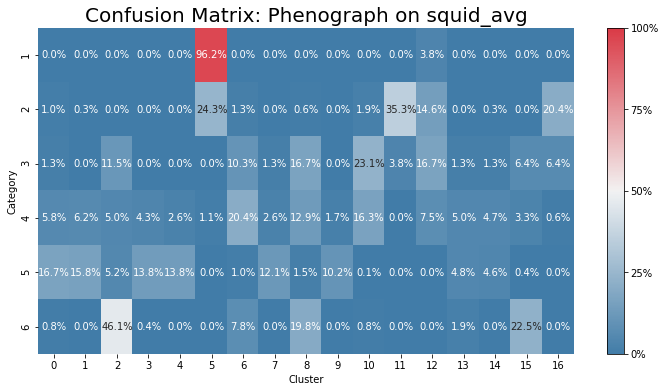

In [21]:
conf_mat_avg = getConfMat(ytrain, communities_avg)
plotConfMat(conf_mat_avg, figsize=(12,6), title="Confusion Matrix: Phenograph on squid_avg")

The AMI score is 0.358


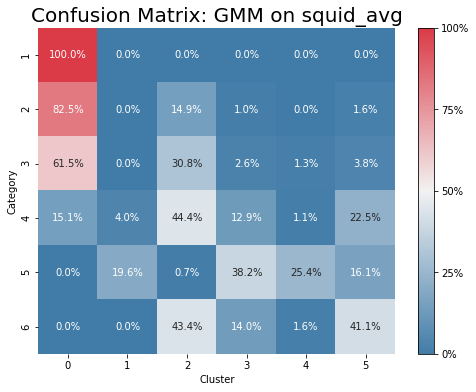

In [26]:
gmm = GaussianMixture(n_components=6, n_init=3, random_state=SEED)
gmm.fit(xtrain_input_avg)
gmm_communities_avg = gmm.predict(xtrain_input_avg)
conf_mat_gmm_avg = getConfMat(ytrain, gmm_communities_avg)
plotConfMat(conf_mat_gmm_avg, figsize=(8,6), title="Confusion Matrix: GMM on squid_avg")

The AMI score is 0.097


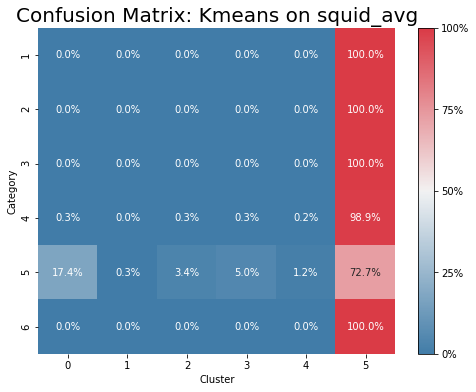

In [29]:
km = KMeans(n_clusters=6, random_state=SEED)
km.fit(xtrain_input_avg)
km_communities_avg = km.predict(xtrain_input_avg)
conf_mat_km_avg = getConfMat(ytrain, km_communities_avg)
plotConfMat(conf_mat_km_avg, figsize=(8,6), title="Confusion Matrix: Kmeans on squid_avg")